In [1]:
# from photutils import aperture_photometry

# positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
# apertures_r3 = CircularAperture(positions, r=3.)

# from photutils import CircularAnnulus

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from astropy.io import fits
from astropy.stats import sigma_clipped_stats
from photutils import aperture_photometry,CircularAnnulus,CircularAperture
from photutils import DAOStarFinder

In [38]:
image = 'hor1DRCs/jdan20010_drc.fits'

# fits.info(image)

hdu = fits.open(image)
sci = hdu[1].data
hdr = hdu[0].header
tab = hdu[4].data
photflam = hdu[1].header['PHOTFLAM']

data = hdu[1].data[500:1000,2500:3000]
hdu.close()

In [15]:
# temp_sci = data*hdr['texptime'] + (0.03/0.05)**2*np.sum(tab['mdrizsky'])/2
# temp_sci = data*hdr[]
temp_sci=data*hdr['texptime']

In [16]:
fits.writeto('hor1DRCs/F814W_cts_raw.fits', temp_sci, header=hdr)

In [39]:
# data = np.genfromtxt('hor1DRCs/F814W_cts.fits')

image = 'hor1DRCs/F814W_cts_raw.fits'
# fits.info(image)

hdu = fits.open(image)
sci = hdu[0].data
hdr = hdu[0].header
hdu.close()

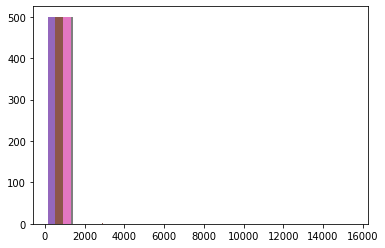

In [52]:
plt.hist(sci)
plt.show()

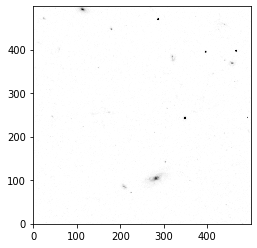

In [18]:
plt.figure()
plt.imshow(sci, cmap='Greys', origin='lower',\
           vmin=10,vmax=1000)


In [19]:
data = sci.copy()

In [20]:
# from astropy.stats import sigma_clipped_stats
# from photutils import DAOStarFinder

mean, median, std = sigma_clipped_stats(data, sigma=3.0, maxiters=5)
print(mean, median, std)
# exptime = 4627

0.7833574 0.24688913 18.31525


In [21]:
daofind = DAOStarFinder(fwhm=2., threshold=3.*std)
sources = daofind(data - median)
print(len(sources))

743


In [22]:
positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
apertures_r3 = CircularAperture(positions, r=3.)

rawflux_r3 = aperture_photometry(data, apertures_r3)
print(rawflux_r3)

 id      xcenter            ycenter           aperture_sum   
           pix                pix                            
--- ------------------ ------------------ -------------------
  1  248.0285924016749 0.5283920933150006  334.40853929454414
  2 480.38402205176016 0.6892322828875614  1218.3524759541936
  3  489.9863156416627 0.5864856957907001   45.26309575696186
  4  29.70983466966191 2.4624043672187708     438.83689658949
  5 260.32338290432415 3.6870503778231734   145.1404446702453
  6 423.12733186041146 1.7344984415698061  316.06064626972284
  7  324.7171617593559  6.502552178235311   375.5643340770555
  8 217.22762585079718  7.538491996453394  350.12134019370717
  9 348.71239281752577  7.278403750195628  211.52186553947615
 10  360.7626031617271   7.54609619654271   239.8532031628913
...                ...                ...                 ...
734 123.23604598669608 493.21006946752067  3907.2956259256443
735 233.16210639047048  493.6664715493816  165.86063268389375
736 200.

In [27]:
annulus_apertures = CircularAnnulus(positions, r_in=8., r_out=12.)

annulus_masks = annulus_apertures.to_mask(method='center')

bkg_median = []
for mask in annulus_masks:
    
    annulus_data = mask.multiply(data)
    annulus_data_1d = annulus_data[mask.data > 0]
    _, median_sigclip, _ = sigma_clipped_stats(annulus_data_1d)
    bkg_median.append(median_sigclip)

bkg_median = np.array(bkg_median)

In [28]:
rawflux_r3['annulus_median'] = bkg_median
print(rawflux_r3['annulus_median'])

  annulus_median  
------------------
               0.0
               0.0
               0.0
               0.0
               0.0
               0.0
               0.0
               0.0
               0.0
               0.0
               ...
               0.0
23.104639053344727
               0.0
               0.0
               0.0
               0.0
               0.0
               0.0
               0.0
               0.0
               0.0
Length = 743 rows


In [29]:
rawflux_r3['aper_bkg'] = bkg_median*apertures_r3.area
print(rawflux_r3['aper_bkg'][0:10])

aper_bkg
--------
     0.0
     0.0
     0.0
     0.0
     0.0
     0.0
     0.0
     0.0
     0.0
     0.0


In [30]:
rawflux_r3['final_phot'] = rawflux_r3['aperture_sum'] - rawflux_r3['aper_bkg']
print(rawflux_r3['final_phot'][0:10])

    final_phot    
------------------
334.40853929454414
1218.3524759541936
 45.26309575696186
   438.83689658949
 145.1404446702453
316.06064626972284
 375.5643340770555
350.12134019370717
211.52186553947615
 239.8532031628913


In [31]:
apertures_r5 = CircularAperture(positions, r=5.)
rawflux_r5 = aperture_photometry(data, apertures_r5)

rawflux_r5['aper_bkg'] = rawflux_r3['annulus_median']*apertures_r5.area
rawflux_r5['final_phot'] = rawflux_r5['aperture_sum'] - rawflux_r5['aper_bkg']
print(rawflux_r5['final_phot'][0:10])
print(rawflux_r5[rawflux_r5['final_phot'] < 0]['ycenter'][0:10])

    final_phot    
------------------
  369.698237574607
 1360.647567451715
450.37778376317476
 358.4960653735161
102.70345567394975
214.23442814722324
 521.4846524627324
321.63134465599796
 252.2400428459848
 233.4211017743644
[17.10268304 21.16598519 23.7749154  29.9532561  30.89047291 37.59827456
 45.01268515 48.33629131 51.49165148 57.77444155] pix


In [32]:
mask_negative = (rawflux_r3['final_phot'] > 0) & (rawflux_r5['final_phot'] > 0)

rawflux_pos_r3 = rawflux_r3[mask_negative]
rawflux_pos_r5 = rawflux_r5[mask_negative]

mag_r3 = -2.5*np.log10(rawflux_pos_r3['final_phot'])
mag_r5 = -2.5*np.log10(rawflux_pos_r5['final_phot'])

deltamag = mag_r3 - mag_r5
print(deltamag[0:10])

     final_phot     
--------------------
 0.10892505341813674
  0.1199317483963247
  2.4945817635150878
 -0.2195468540539851
 -0.3755084817770218
-0.42220289801056765
  0.3563929730282327
-0.09215053945871787
 0.19114690845345983
-0.02951352014137676


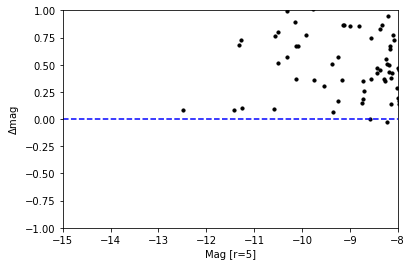

In [33]:
plt.figure()
plt.scatter(mag_r5, deltamag, c='k', s=10)
plt.axhline(ls='--', c='b')
plt.xlim(-15,-8)
plt.ylim(-1,1)
plt.xlabel('Mag [r=5]')
plt.ylabel('$\Delta$mag')

plt.show()

In [34]:
ap_cor = -2.5 * np.log10(0.770)
zpt = 26.779

In [42]:
other = -2.5*np.log10(photflam/hdr['texptime']/0.770)

In [44]:
final_phot = -2.5*np.log10(rawflux_pos_r3['final_phot']) + other - zpt
print(final_phot[:10])

    final_phot    
------------------
 23.55711616469947
 22.15337718626687
 25.72844892659005
23.262051724031135
24.463338438540102
 23.61838350230637
   23.431098706181
23.507263106329656
24.054421391483498
23.917945755043224


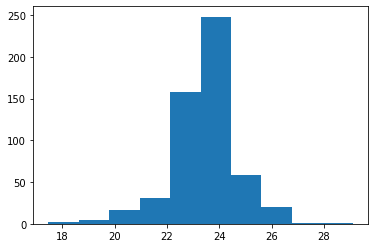

In [45]:
plt.hist(final_phot)
plt.show()

# Earlier Work

In [6]:
temp_sci = sci*hdr['texptime'] + (0.03/0.05)**2*np.sum(tab['mdrizsky'])/2

In [7]:
pos_file = np.genfromtxt('sDRC_2606/matchedDRCaper2906_bkgd.dat',names=True)

In [8]:
xpos = pos_file['xr_f606w']-0.5
ypos = pos_file['yr_f606w']-0.5

In [9]:
loc = np.array([xpos,ypos])
print(loc.shape)

positions = np.transpose(loc)
print(positions.shape)
print(positions[:10,:])

(2, 1368)
(1368, 2)
[[4076.4058  576.1948]
 [4109.1333 1023.4497]
 [4109.0664 2540.4456]
 [4143.6416 2033.4398]
 [4071.4421 1742.3646]
 [3998.9187  667.9089]
 [4002.3486 1445.111 ]
 [3984.6777  194.568 ]
 [4065.0552 1337.8058]
 [4011.4626  259.3171]]


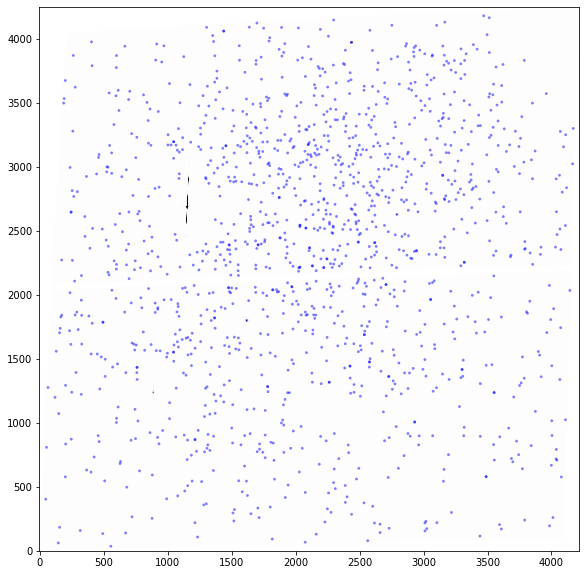

In [10]:
apertures = CircularAperture(positions, r=5.)

fig,ax = plt.subplots(figsize=(10,10))

ax.imshow(sci, cmap='Greys', origin='lower')
apertures.plot(color='blue', lw=1.5, alpha=0.5)


plt.show()

In [11]:
apertures_r4 = CircularAperture(positions, r=4.)

rawflux_r4 = aperture_photometry(temp_sci, apertures_r4)
print(rawflux_r4)

 id   xcenter   ycenter     aperture_sum   
        pix       pix                      
---- --------- --------- ------------------
   1 4076.4058  576.1948  6953.070113856595
   2 4109.1333 1023.4497 10184.498645541324
   3 4109.0664 2540.4456 10531.845182432997
   4 4143.6416 2033.4398   48665.6532763354
   5 4071.4421 1742.3646  31564.13250783851
   6 3998.9187  667.9089  7364.973176135653
   7 4002.3486  1445.111 6813.4822799646545
   8 3984.6777   194.568 10213.525019173285
   9 4065.0552 1337.8058  6767.600159397084
  10 4011.4626  259.3171  13093.16144358292
 ...       ...       ...                ...
1359  174.0259 1840.0088   9179.31076473029
1360  161.6744 1737.4998  23365.85771030307
1361  156.8175  1703.041  8017.904154396545
1362  238.8237 2994.5317 16152.329257549332
1363  260.1625 3278.1619  10887.12336836542
1364  264.2503 3869.4104  7491.402236222572
1365  278.8444 3621.6318   6895.11746275246
1366  188.6674 3497.2051  18458.84110983001
1367  192.3142 3532.7405 11750.3

In [12]:
annulus_apertures = CircularAnnulus(positions, r_in=9., r_out=12.)

In [13]:
data = temp_sci.copy()

In [14]:
annulus_masks = annulus_apertures.to_mask(method='center')

bkg_median = []
for mask in annulus_masks:
    
    annulus_data = mask.multiply(data)
    annulus_data_1d = annulus_data[mask.data > 0]
    _, median_sigclip, _ = sigma_clipped_stats(annulus_data_1d)
    bkg_median.append(median_sigclip)

bkg_median = np.array(bkg_median)

In [15]:
rawflux_r4['annulus_median'] = bkg_median
print(rawflux_r4['annulus_median'])

  annulus_median  
------------------
108.01699829101562
107.18997192382812
  101.963623046875
112.19859313964844
104.70746612548828
106.61402130126953
105.77669525146484
113.19987869262695
108.77640533447266
112.89155578613281
               ...
105.73811721801758
107.89606094360352
109.34430313110352
107.22586059570312
105.10013580322266
109.50621032714844
115.75445556640625
106.79839706420898
116.36150360107422
 106.6308822631836
116.78489303588867
Length = 1368 rows


In [16]:
rawflux_r4['aper_bkg'] = bkg_median*apertures_r4.area
print(rawflux_r4['aper_bkg'])

     aper_bkg     
------------------
 5429.526532702015
 5387.955653350314
 5125.250705559382
 5639.716415210075
 5263.171301693377
 5359.005217435745
 5316.916619568133
 5690.046516608201
 5467.698494122958
5674.5485169605945
               ...
 5314.977476104647
 5423.447558587222
 5496.244150857124
 5389.759614756867
 5282.909032491102
 5504.382494179652
 5818.453555643328
 5368.272954113355
 5848.967117980752
 5359.852741821052
 5870.248992189082
Length = 1368 rows


In [17]:
rawflux_r4['final_phot'] = rawflux_r4['aperture_sum'] - rawflux_r4['aper_bkg']
print(rawflux_r4['final_phot'])

    final_phot    
------------------
1523.5435811545794
  4796.54299219101
 5406.594476873614
 43025.93686112532
26300.961206145133
2005.9679586999082
1496.5656603965217
4523.4785025650835
1299.9016652741257
 7418.612926622325
               ...
 4566.288119860644
 3755.863206143067
17869.613559445945
2628.1445396396775
10869.420225058231
 5382.740874185769
 1672.948680579244
1526.8445086391048
12609.873991849257
 6390.461350352509
 32228.20292985956
Length = 1368 rows


In [18]:
EEVband = 0.839 #4 pix rad
EEIband  = 0.830 #4 pix rad

ZPV = 26.667
ZPI = 26.779

In [19]:
mask_negative = (rawflux_r4['final_phot'] > 0) 
rawflux_pos_r4 = rawflux_r4[mask_negative]

In [ ]:
other = -2.5*np.log10(photflam/hdr['texptime']/EEVband)

In [20]:
# final_phot = -2.5*np.log10(rawflux_pos_r4['final_phot']/EEVband) + ZPV
final_phot = -2.5*np.log10(rawflux_pos_r3['final_phot']) + other - ZPV
print(final_phot)

    final_phot    
------------------
18.519267697610957
17.274084048383862
 17.14409541102558
 14.89207906313247
15.426475850343875
18.220594922672515
 18.53866546244174
17.337723575293804
 18.69162865177409
 16.80059812223882
               ...
17.327496625142253
17.539630486416634
15.846117000216552
17.927281786152104
16.385888953487374
17.148896218750238
18.417698355229266
 18.51691787340979
 16.22462803514697
 16.96257437065082
15.205814678114423
Length = 1368 rows


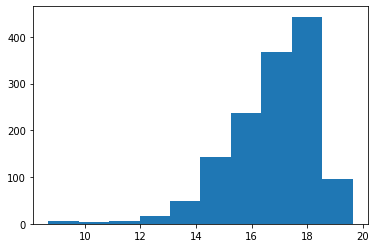

In [21]:
plt.hist(final_phot)
plt.show()

In [22]:
flux = 10**((pos_file['magr_f606w'] - ZPV)/(-2.5) ) *EEVband
print(flux[:10])

[0.34251687 1.04424393 1.14246252 9.32657014 5.69799365 0.43355277
 0.32988454 0.99899189 0.33244665 1.62810332]


In [23]:
image = 'hor1DRCs/jdan21010_drc.fits'

hdu = fits.open(image)
sci = hdu[1].data
hdr2 = hdu[0].header
tab = hdu[4].data

hdu.close()

In [24]:
temp_sci = sci*hdr2['texptime'] + (0.03/0.05)**2*np.sum(tab['mdrizsky'])/2

xpos = pos_file['xr_f814w']-0.5
ypos = pos_file['yr_f814w']-0.5

loc = np.array([xpos,ypos])

positions = np.transpose(loc)

apertures_r4 = CircularAperture(positions, r=4.)

rawflux_r4_814 = aperture_photometry(temp_sci, apertures_r4)
annulus_apertures = CircularAnnulus(positions, r_in=9., r_out=12.)

data = temp_sci.copy()

annulus_masks = annulus_apertures.to_mask(method='center')

bkg_median = []
for mask in annulus_masks:
    
    annulus_data = mask.multiply(data)
    annulus_data_1d = annulus_data[mask.data > 0]
    _, median_sigclip, _ = sigma_clipped_stats(annulus_data_1d)
    bkg_median.append(median_sigclip)

bkg_median = np.array(bkg_median)

In [25]:
rawflux_r4_814['annulus_median'] = bkg_median
rawflux_r4_814['aper_bkg'] = bkg_median*apertures_r4.area
rawflux_r4_814['final_phot'] = rawflux_r4_814['aperture_sum'] - rawflux_r4_814['aper_bkg']

mask_negative = (rawflux_r4_814['final_phot'] > 0) 
rawflux_pos_r4_814 = rawflux_r4_814[mask_negative]

final_phot_814 = -2.5*np.log10(rawflux_pos_r4_814['final_phot']/EEVband) + ZPV
print(final_phot_814)

    final_phot    
------------------
18.590470163881463
17.320344783707476
 17.40899732477817
 15.38750723993363
15.827129904136273
18.124054714620577
18.594236080091093
17.890066352126645
18.524168560694157
16.947810886848536
               ...
17.485333672209034
17.686531103896158
 16.29720587390009
 18.80344526899605
16.746626776195292
17.342129643904386
17.802745923955502
18.623889040965167
16.621535789580744
17.193338069706787
15.702416393586184
Length = 1368 rows


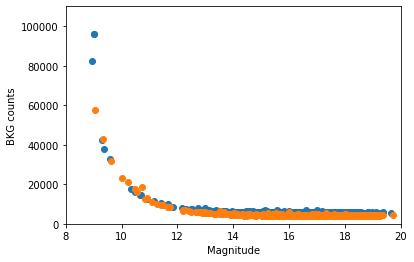

In [26]:
fig, ax = plt.subplots()

# ax.scatter(final_phot,rawflux_r4['aper_bkg']/hdr['texptime'])
# ax.scatter(final_phot_814,rawflux_r4_814['aper_bkg']/hdr2['texptime'])

ax.scatter(final_phot,rawflux_r4['aper_bkg'])
ax.scatter(final_phot_814,rawflux_r4_814['aper_bkg'])

ax.set_ylabel('BKG counts')
ax.set_xlabel('Magnitude')

ax.set_ylim(0,110000)
ax.set_xlim(8,20)

plt.show()

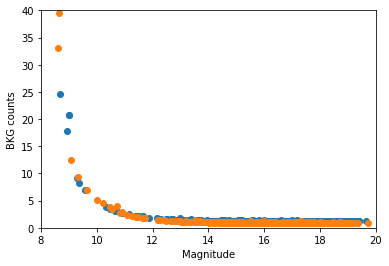

In [31]:
fig, ax = plt.subplots()

ax.scatter(final_phot,rawflux_r4['aper_bkg']/hdr['texptime'])
ax.scatter(final_phot_814,rawflux_r4_814['aper_bkg']/hdr2['texptime'])

# ax.scatter(final_phot,rawflux_r4['aper_bkg'])
# ax.scatter(final_phot_814,rawflux_r4_814['aper_bkg'])

ax.set_ylabel('BKG counts')
ax.set_xlabel('Magnitude')

ax.set_ylim(0,40)
ax.set_xlim(8,20)

plt.show()

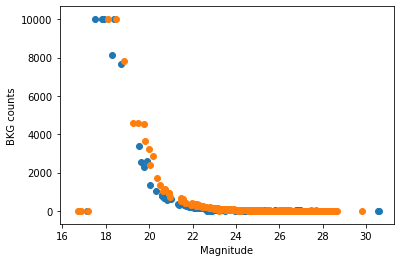

In [28]:
fig, ax = plt.subplots()

ax.scatter(pos_file['m606cAPER'],pos_file['sky606APER'])
ax.scatter(pos_file['m814cAPER'],pos_file['sky814APER'])

ax.set_ylabel('BKG counts')
ax.set_xlabel('Magnitude')

# ax.set_ylim(0,40)
# ax.set_xlim(8,20)

plt.show()

In [29]:
tab['mdrizsky']

array([52.74571609, 52.74571609, 67.36671448, 67.36671448,  4.54804945,
        4.54804945, 51.5254631 , 51.5254631 , 55.70343399, 55.70343399])

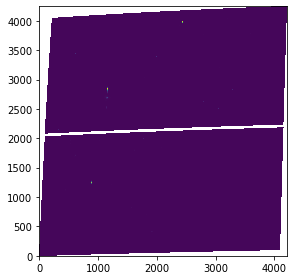

In [30]:
fig,ax = plt.subplots()

ax.imshow(sci,origin='lower',interpolation='nearest')
plt.tight_layout()
plt.show()